# City lighting benchmarking

This notebook presents an analysis of cities using remote-sensing data on macro-level socio-demographic indicators. In particular, we characterize cities by the dependence with distance (from the city center) of several macroeconomic quantities:
* built areas $x_{bldg}(d)$ estimated from SAR/GUF data
* population density $x_{pop}(d)$ estimated from LandScan data
* luminosity $x_{lum}(d)$ estimated from VIIRS (nightlights) data.

We model each quantity (population, luminosity, built area) by breaking it down into a scale component and a spatial profile component:

<p><center> $\displaystyle x(d) = c \cdot \hat{x}(d)$ </center></p>

We analyze cities from the perspective of patterns in each of the components $c$ and $\hat{x}(\cdot)$. We'll have one such set of objects for each data source we consider (population, luminosity, building density).

We expect (as shown empirically below) that the distribution of the scale factor $c$ across cities is heavily skewed towards small $c$, and is approximately a log-normal. 

At the same time, prior research on urban form typically models the relationship of $x (d)$ with distance $d$ using an exponential form:

<p><center> $\displaystyle x(d) = x_0 e^{-\gamma d}$ </center></p>

Above, $\gamma$ is the _average (radial) spatial gradient_ which previous studies (e.g., Alain Bertaud's work) have investigated. This can be estimated readily via linear regression:

<p><center> $\displaystyle \text{log } x(d) = \text{log } x_0 -\gamma d$ </center></p>

(Note we will use 10-base logarithm, but still refer to it as _log_ for ease of notation.)

The two expressions for $x(d)$ are equivalent, so $c$ could be identified as $\text{log }x_0$, but we'll prefer to retain the scale factor $c$, because it has a more direct interpretation. 

Three questions are of interest:
* what are "classes" of cities with respect to their average mass (pop, lum, bld) and its spatial distribution quantified by $\hat x_{\cdot} (d)$?
* where is there "less light" than the population profile would imply? by how much? how much "effort" would it be to match the light distribution with the population distribution? 
* can we compare citie's luminosity profiles more objectively against those of "similar cities"? I.e., build a model to benchmark cities' luminosity distribution in space.


# Packages

In [2]:
import numpy as np
import pandas as pd

import geopandas as gpd
import shapely.wkt
from shapely import geometry
import geojson
from shapely.geometry import shape
from shapely.wkt import loads

import re

import sys, os, time
import glob

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

%matplotlib inline

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

# widgets and interaction
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})

from skimage.io import imread, imsave

import warnings
warnings.filterwarnings('ignore')

import gzip
import cPickle as pickle
import copy

colormap = {"bldg":"black", "pop":"green", "lum":"orange", 
            "all":"blue", "bnds":"gray"}

cmap_bld = sns.light_palette("black", n_colors=4)
cmap_pop = sns.light_palette("green", n_colors=10)
cmap_lum = sns.light_palette("orange",n_colors=10)


cmap_dict = {"bldg":ListedColormap(cmap_bld), 
             "pop":ListedColormap(cmap_pop), 
             "lum":ListedColormap(cmap_lum)}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load city feature data for analysis

#### Data on raw variable profiles with distance

In [3]:
# load pre-computed profile data

dataroot = "/home/data/world-cities/"

with gzip.open(dataroot + "spatial-maps/stats_cities_over10kpop.pickle.gz", "r") as f:
    cities = pickle.load(f)
print len(cities)  

# load pruned list of cities
cities_sel_df = pd.read_csv(dataroot + "/selected_urban_areas_100k.csv").drop("index",axis=1)

parse_location = lambda s: shape(loads(s))
cities_sel_df['location'] = cities_sel_df['location'].apply(parse_location)
cities_sel_df['population'] = cities_sel_df['population'].astype(int)

def include(v):
    return ((cities_sel_df.city.str.contains(v['city'])) & \
           (cities_sel_df.population==v['population']) & \
           (cities_sel_df.country.str.contains(v['country']))).sum()>0 
 
cities_sel = {k:v for k,v in cities.iteritems() if include(v) and \
                v['sum area']['bldg']>0 and v['sum area']['pop']>0 and v['sum area']['pop']>0 and \
                v['profiles']['bldg'][0].sum()>0 and v['profiles']['pop'][0].sum()>0 and v['profiles']['lum'][0].sum()>0}
print len(cities_sel)

L = len(cities.values()[0]['profiles']['bldg'][0]) # length of profile in km
distance_km = np.arange(L)

29850
6936


In [ ]:
cities_sel.drop("geometry", 1).to_csv(dataroot + "/cities_over_100k.csv")

#### Helper function to load image data

In [5]:
import glob

files = glob.glob(dataroot + "spatial-maps/samples/*.tif")
files_dict = {}
for f in files:
    s = f.split("/")
    fname = s[-1]
    country,province,city,pop_class,pop,lat,lon = fname.split("_")
    files_dict[(city.replace("-"," "),country.replace("-"," "), int(pop))] = f
print len(files_dict)

29850


In [6]:
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv

def get_image_data(city_info, imgSize=None, take_log=False):
    fname = files_dict[city_info]
    img = imread(fname)
    if imgSize is not None:
        img = resize(img, (imgSize, imgSize), preserve_range=True)
    f = np.log if take_log else lambda x: x
    mask = img[...,3]==0
    for i in range(3):
        img[...,i] = f(img[...,i]); img[...,i][mask] = np.nan
        img[...,i] = (img[...,i] - np.nanmin(img[...,i])) / float((np.nanmax(img[...,i]) - np.nanmin(img[...,i])))
    return {'bldg':img[...,0], 
            'pop':img[...,1], 
            'lum':img[...,2], 
            'wtr':mask,
            'bnd':img[...,4]} 

def format_pop(pop):
    if pop > 1e6:
        div = 1e6
        s = 'M'
    else:
        div = 1e3
        s = 'k'
    return "%2.1f%s"%(float(pop)/div, s)

import matplotlib.cm as cm

def overlay_mask(img, mask, ax, alpha=0.1, cmap=cm.GnBu):
    masked_data = np.ma.masked_where(mask, img)
    # Overlay the two images
    ax.imshow(img, cmap=cmap)
    ax.imshow(masked_data, cmap=cm.gray, interpolation='none', alpha=alpha)

In [57]:
sys.path.append("/home/nbserver/urbanization-patterns/cityanalysis/")
from normalized_colorbar import shiftedColorMap
from scipy import stats

def create_diverging_colormap(arr, cmap, pmin=0.0, pmax=100):
    # create a suitable colormap for display
    vmin = np.percentile(arr, pmin)
    vmax = np.percentile(arr, pmax)
    pct_zero = 1 - vmax/(vmax + abs(vmin)) 
    cmap = shiftedColorMap(cmap, name='shiftedcmap_dis',
                               start=0.0, midpoint=pct_zero, stop=1.0)
    return cmap

cmap_coolwarm = sns.diverging_palette(255, 0, sep=5, n=30, as_cmap=True)
cmap_lumpop = sns.diverging_palette(55, 120, s=90, l=70, n=10, as_cmap=True)

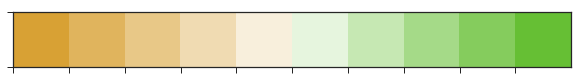

In [59]:
sns.palplot(sns.diverging_palette(55, 120, s=90, l=70, n=10))

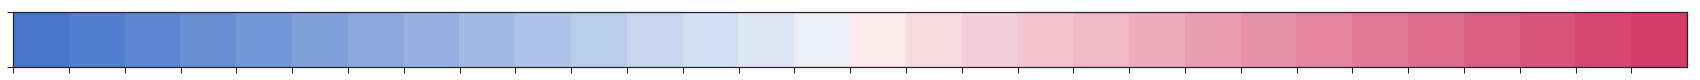

In [60]:
sns.palplot(sns.diverging_palette(255, 0, sep=5, n=30, ))

# Analyze city scale

#### Format scale data

In [11]:
scales_within = np.vstack([
                    [v['avg area bnds']['bldg'] for k,v in cities_sel.iteritems()],
                    [v['population'] for k,v in cities_sel.iteritems()],
                    [v['avg area bnds']['lum'] for k,v in cities_sel.iteritems()]
]).T

scales_total = np.vstack([
                    [v['avg area']['bldg'] for k,v in cities_sel.iteritems()],
                    [v['sum area']['pop'] for k,v in cities_sel.iteritems()],
                    [v['avg area']['lum'] for k,v in cities_sel.iteritems()]
 ]).T

scales_max = np.vstack([
                    [v['profiles']['bldg'][0].max() for k,v in cities_sel.iteritems()],
                    [v['profiles']['pop'][0].max() for k,v in cities_sel.iteritems()],
                    [v['profiles']['lum'][0].max() for k,v in cities_sel.iteritems()]   
]).T

scales = np.hstack([scales_within, scales_total, scales_max])
columns_scales = ["bldg-in", "pop-in", "lum-in", 
                  "bldg-tot", "pop-tot", "lum-tot",
                  "bldg-max", "pop-max", "lum-max"]
scales_df = pd.DataFrame(scales, columns=columns_scales)
scales_df.fillna(0, inplace=True)

info_df = pd.DataFrame(np.array(
                        [[v['city'] for k,v in cities_sel.iteritems()],
                         [v['country'] for k,v in cities_sel.iteritems()],
                         [int(float(v['population'])) for k,v in cities_sel.iteritems()],
                         [v['size'] for k,v in cities_sel.iteritems()],
                         [v['subregion'] for k,v in cities_sel.iteritems()],
                         [v['region'] for k,v in cities_sel.iteritems()]]).T,
                      columns=['city', "country", "population", 'scale-pop', 'subregion', 'region'])
info_df['population'] = info_df['population'].astype(int)
scales_df = pd.concat([info_df, scales_df], axis=1)

scales_df.head()

,city,country,population,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max
0,shahdol,india,1237432,large,Southern Asia,Asia,0.006481,1237432.0,0.248668,0.005900,1.328246e+06,0.239223,0.021277,169.818182,0.365241
1,lafia,nigeria,364173,small-2,Western Africa,Africa,0.018068,364173.0,0.036361,0.011078,1.214261e+06,0.033401,0.066016,211.490566,0.514750
2,ibarapa central,nigeria,120329,small-1,Western Africa,Africa,0.013719,120329.0,0.003794,0.016098,1.693468e+06,0.049525,0.057143,181.828571,0.036187
3,hamilton,united states,360445,small-2,Northern America,Americas,0.091867,360445.0,6.460299,0.030764,7.966306e+05,2.176872,0.491170,249.800000,6.014977
4,purnia,india,3385281,large,Southern Asia,Asia,0.040247,3385281.0,0.440284,0.034887,1.017604e+07,0.412417,0.126283,833.989011,0.950606


#### Create scale-based classifications for bld and lum

For population we have a standard classification system (5 classes of cities by population). Let's create a simple classification for built density and for luminosity.

For each dimension (lum, bld) we can try different statistics to classify by
* average within bounds
* average total (including city + 50km area around city center)
* maximum density

In [93]:
typ = "tot"
classes = ['low', 'med', 'hi']
classes_order = dict(zip(classes, range(len(classes))))

q_bld = np.percentile(scales_df['bldg-%s'%typ].dropna(), (0,25, 75,100))
scales_df['scale-bldg'] = ''
for p in range(3):
    idx = (scales_df['bldg-%s'%typ]>=q_bld[p]) & (scales_df['bldg-%s'%typ]<=q_bld[p+1])
    scales_df.ix[idx,'scale-bldg'] = classes[p]

q_lum = np.percentile(scales_df['lum-%s'%typ].dropna(), (0,25, 75,100))
scales_df['scale-lum'] = ''
for p in range(3):
    idx = (scales_df['lum-%s'%typ]>=q_lum[p]) & (scales_df['lum-%s'%typ]<=q_lum[p+1])
    scales_df.ix[idx,'scale-lum'] = classes[p]

scales_df['scale-bldg-lum'] = map(lambda x,y: "bldg:%d-%s,lum:%d-%s"%(classes_order[x],x,classes_order[y],y),
                             scales_df['scale-bldg'], scales_df['scale-lum'])

In [94]:
tmp = scales_df['scale-bldg-lum'].unique()
tmp.sort()
tmp

array(['bldg:0-low,lum:0-low', 'bldg:0-low,lum:1-med',
       'bldg:0-low,lum:2-hi', 'bldg:1-med,lum:0-low',
       'bldg:1-med,lum:1-med', 'bldg:1-med,lum:2-hi',
       'bldg:2-hi,lum:1-med', 'bldg:2-hi,lum:2-hi'], dtype=object)

In [95]:
scales_df.head()

,city,country,population,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max,scale-bldg,scale-lum,scale-bldg-lum
0,shahdol,india,1237432,large,Southern Asia,Asia,0.006481,1237432.0,0.248668,0.005900,1.328246e+06,0.239223,0.021277,169.818182,0.365241,low,med,"bldg:0-low,lum:1-med"
1,lafia,nigeria,364173,small-2,Western Africa,Africa,0.018068,364173.0,0.036361,0.011078,1.214261e+06,0.033401,0.066016,211.490566,0.514750,med,low,"bldg:1-med,lum:0-low"
2,ibarapa central,nigeria,120329,small-1,Western Africa,Africa,0.013719,120329.0,0.003794,0.016098,1.693468e+06,0.049525,0.057143,181.828571,0.036187,med,low,"bldg:1-med,lum:0-low"
3,hamilton,united states,360445,small-2,Northern America,Americas,0.091867,360445.0,6.460299,0.030764,7.966306e+05,2.176872,0.491170,249.800000,6.014977,med,hi,"bldg:1-med,lum:2-hi"
4,purnia,india,3385281,large,Southern Asia,Asia,0.040247,3385281.0,0.440284,0.034887,1.017604e+07,0.412417,0.126283,833.989011,0.950606,med,med,"bldg:1-med,lum:1-med"


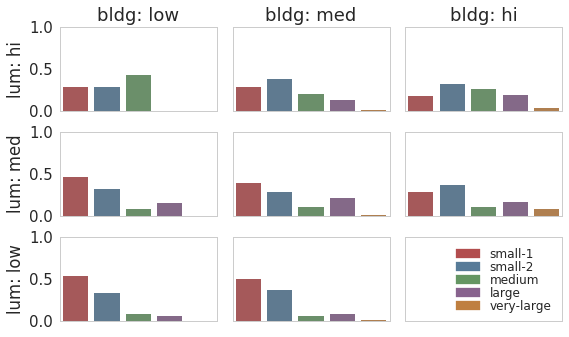

In [13]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots(3,3, figsize=(9,6),
                      gridspec_kw={"wspace":0.1, "hspace":0.25},
                      sharex=True, sharey=True)
pop_scales = ["small-1", "small-2", "medium", "large", "very-large"]
pop_colors = sns.color_palette("Set1", n_colors=len(pop_scales), desat=.5)
for i,l in enumerate(["hi", "med", "low"]):
    for j,b in enumerate(["low", "med", "hi"]):
        a = ax[i,j]
        cur_df = scales_df[(scales_df['scale-lum']==l) & (scales_df['scale-bldg']==b)]
        a.set_xlabel(''); a.set_ylabel('')
        a.set_xticklabels(a.get_xticklabels(), rotation=60)
        a.set_ylim([0, 1])

        if i==0:
            a.set_title("bldg: %s"%b)
        if j==0:
            a.set_ylabel("lum: %s"%l)
        if len(cur_df) < 3:
            continue
#         pcts = cur_df.groupby("scale-pop").apply(lambda x: x['region'].value_counts()/float(len(x)))
#         pcts = pd.DataFrame(pcts).reset_index()
#         pcts.columns = ["scale-pop", "region", "pct"]
#         g = sns.barplot(x="region", y="pct", hue="scale-pop", 
#                         data=pcts, ax=a)
        pcts = cur_df['scale-pop'].value_counts() / float(len(cur_df))
        g = sns.barplot(pcts.index, pcts.values, order=pop_scales, ax=a,
                       palette=pop_colors)
        # a.legend_.remove() #, bbox_to_anchor=(1.1, 1.05))
  
# fig.delaxes(ax[2,0])
# ax[2,0].set_xticks([]); ax[2,0].set_yticks([])

import matplotlib.patches as mpatches

legend_patches = [mpatches.Patch(color=c, label=l) \
                  for l,c in zip(pop_scales, pop_colors)]

ax[-1,-1].legend(handles=legend_patches, bbox_to_anchor=(1,1),
           ncol=1, labelspacing=0., fontsize=12)

fig.subplots_adjust(bottom=0.2)
fig.savefig('../figures/scale_classification.svg', format='svg', dpi=1200)

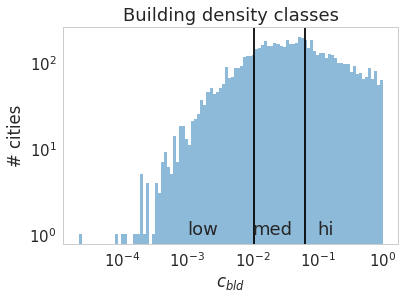

In [14]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots()
scales_df['bldg-in'].apply(lambda x: np.log10(x) if x>0 else np.nan).hist(bins=100, log=True, figsize=(6,4), alpha=0.5, ax=ax)
for q in q_bld[1:-1]:
    ax.axvline(x=np.log10(q), color=colormap["bldg"])
ax.set_title("Building density classes")
ax.set_xlabel("$c_{bld}$")
ax.set_ylabel("# cities")
ax.grid(False)
fig.canvas.draw()
new_labels = ["$10^{%s}$"%x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
ax.annotate("low", xy=(-3,1))
ax.annotate("med", xy=(-2,1))
ax.annotate("hi", xy=(-1,1))

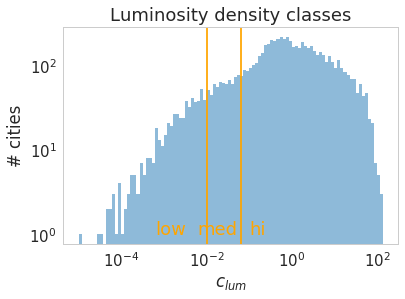

In [15]:
sns.set_context("notebook", font_scale=1.5)

fig, ax = plt.subplots()
scales_df['lum-in'].apply(lambda x: np.log10(x) if x>0 else np.nan).hist(bins=100, log=True, figsize=(6,4), alpha=0.5, ax=ax)
for q in q_bld[1:-1]:
    ax.axvline(x=np.log10(q), color=colormap["lum"])
ax.set_title("Luminosity density classes")
ax.set_xlabel("$c_{lum}$")
ax.set_ylabel("# cities")
ax.grid(False)
fig.canvas.draw()
new_labels = ["$10^{%s}$"%x.get_text() for x in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
ax.annotate("low", xy=(-3.2,1), color=colormap["lum"])
ax.annotate("med", xy=(-2.2,1), color=colormap["lum"])
ax.annotate("hi", xy=(-1,1), color=colormap["lum"])

Let's segment the built-area normalized city scales into _low_, _medium_, and _high_ categories by the percentiles of the marginal distributions for population and density.

In [45]:
scales_df.head()

,city,country,population,scale-pop,subregion,region,bldg-in,pop-in,lum-in,bldg-tot,pop-tot,lum-tot,bldg-max,pop-max,lum-max,scale-bldg,scale-lum,scale-bldg-lum
0,shahdol,india,1237432,large,Southern Asia,Asia,0.006481,1237432.0,0.248668,0.005900,1.328246e+06,0.239223,0.021277,169.818182,0.365241,low,med,"bldg:low,lum:med"
1,lafia,nigeria,364173,small-2,Western Africa,Africa,0.018068,364173.0,0.036361,0.011078,1.214261e+06,0.033401,0.066016,211.490566,0.514750,med,low,"bldg:med,lum:low"
2,ibarapa central,nigeria,120329,small-1,Western Africa,Africa,0.013719,120329.0,0.003794,0.016098,1.693468e+06,0.049525,0.057143,181.828571,0.036187,med,low,"bldg:med,lum:low"
3,hamilton,united states,360445,small-2,Northern America,Americas,0.091867,360445.0,6.460299,0.030764,7.966306e+05,2.176872,0.491170,249.800000,6.014977,med,hi,"bldg:med,lum:hi"
4,purnia,india,3385281,large,Southern Asia,Asia,0.040247,3385281.0,0.440284,0.034887,1.017604e+07,0.412417,0.126283,833.989011,0.950606,med,med,"bldg:med,lum:med"


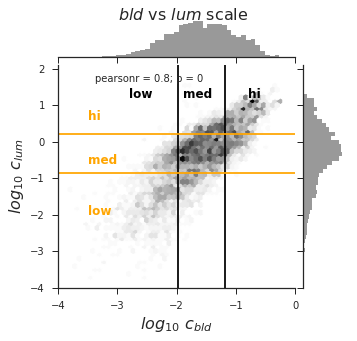

In [19]:
sns.set_context("notebook", font_scale=1.5)
sns.set(style="ticks")

idx_ok = (scales_df['bldg-in']>0) & (scales_df['lum-in']>0)

g = sns.jointplot(np.log10(scales_df['bldg-tot'][idx_ok]), 
                  np.log10(scales_df['lum-tot'][idx_ok]), 
                  kind="hex", color="black", size=5, xlim=(-4,0), ylim=(-4,2.1))
g.fig.suptitle("$bld$ vs $lum$ scale", fontsize=16)
g.ax_joint.set_xlabel("$log_{10} \ c_{bld}$", fontsize=16)
g.ax_joint.set_ylabel("$log_{10} \ c_{lum}$", fontsize=16)

for q in q_bld[1:-1]:
    g.ax_joint.axvline(x=np.log10(q), color=colormap["bldg"])
    
for q in q_lum[1:-1]:
    g.ax_joint.axhline(y=np.log10(q), color=colormap["lum"])
    
for qp,sp in zip([-2.8,-1.9, -0.8], ["low", "med", "hi"]):
    g.ax_joint.annotate(sp, xy=(qp, 1.2), color=colormap["bldg"], weight='bold')   
for qp,sp in zip([0.6, -0.6, -2], ["hi", "med", "low"]):
    g.ax_joint.annotate(sp, xy=(-3.5, qp), color=colormap["lum"], weight='bold')     
    
g.fig.subplots_adjust(bottom=0.2)
g.fig.savefig('../figures/scale_classification_bld_lum.svg', format='svg', dpi=1200)

##### Plot the 8 classes of cities (by scale) on a map

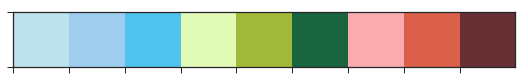

In [98]:
from matplotlib.colors import ListedColormap
import matplotlib

# define a custom color palette
my_colors = [
 (189, 225, 237),
 (159, 205, 237),
 (79, 195, 237),
 # (179, 99, 149),
 # (215, 187, 208),
 # (218, 198, 199),
 (225, 250, 182),
 (161, 185, 59),
 # (214, 227, 140),
 (25, 101, 64),
 (249, 171, 174),
 (218, 96, 75),
 (102, 48, 52),
#  (60, 60, 60),
#  (214, 227, 140),
#  (135, 100, 83),
#  (236, 174, 128)
]

my_colors = [(np.array(v)/float(255)).tolist() + [1.0] for v in my_colors]

cmap_scale = matplotlib.colors.ListedColormap(my_colors)

sns.palplot(sns.color_palette(my_colors))

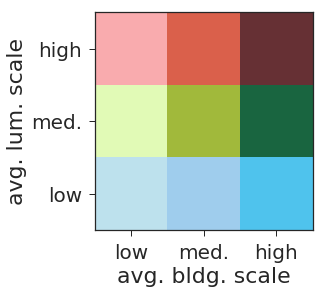

In [106]:
fig, ax = plt.subplots()
ax.imshow(np.flip(np.arange(0, 9).reshape((3,3)),0), cmap=cmap_scale)
ax.set_xlabel("avg. bldg. scale")
ax.set_ylabel("avg. lum. scale")
ax.set_xticks(range(3)); ax.set_xticklabels(["low", "med.", "high"])
ax.set_yticks(range(3)); ax.set_yticklabels(["high", "med.", "low"])
plt.savefig('../figures/colormap_scales.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [79]:
def plot_map(gdf, column="lum", title="", cmap=None, add_colorbar=True):
    sns.set_context("notebook", font_scale=2)
    sns.set(style="ticks", font_scale=2)

    if cmap is None:
        cmap = create_diverging_colormap(gdf[column])
    
    # plot the world map
    fig, ax = plt.subplots(figsize=(18,8))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(ax=ax, 
                    color=[0.99,0.99,0.9,0.1], 
                    edgecolor=[0.8,0.8,0.8,0.9])

    # plot cities
    gdf.plot(ax=ax, marker='.', markersize=7, alpha=0.8, 
                 column=column, cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")

    # add color bar
    if add_colorbar:
        cax = fig.add_axes([0.92, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # fake up the array of the scalar mappable. Urgh...
        sm._A = []
        fig.colorbar(sm, cax=cax)    

In [107]:
scales_gdf = gpd.GeoDataFrame(pd.merge(scales_df, cities_sel_df[["city", "province", "country", "subregion", "location", "population"]], 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
len(scales_gdf)

6936

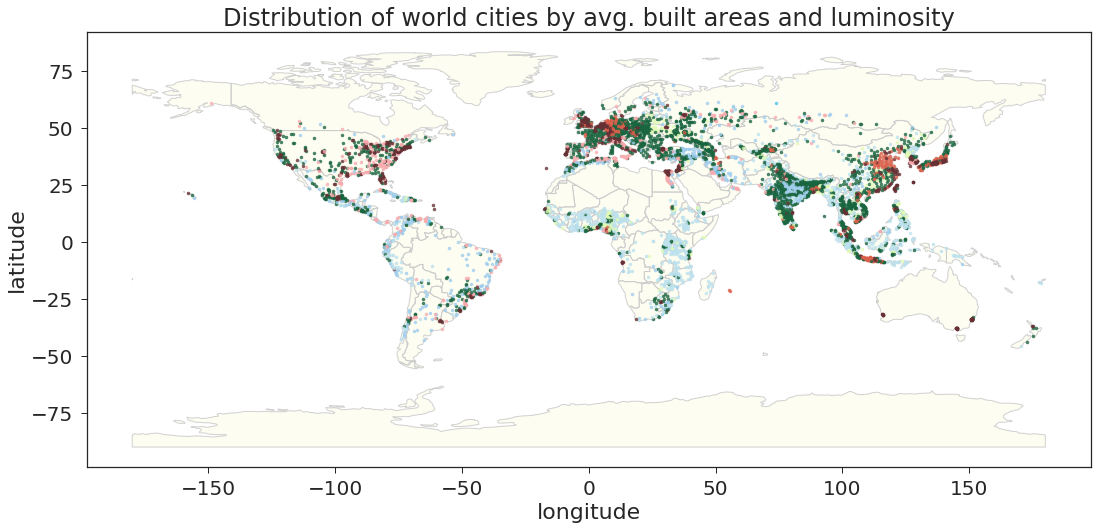

In [108]:
plot_map(scales_gdf, column="scale-bldg-lum", cmap=cmap_scale, add_colorbar=False,
         title="Distribution of world cities by avg. built areas and luminosity")
plt.savefig('../figures/map_distribution_scales_bldg_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

# Analyze profile data

#### Format spatial profile data

In [ ]:
# extract profile data

Xbld = np.vstack([v['profiles']['bldg'][0] for k,v in cities_sel.iteritems()])
Xpop = np.vstack([v['profiles']['pop'][0] for k,v in cities_sel.iteritems()])
Xlum = np.vstack([v['profiles']['lum'][0] for k,v in cities_sel.iteritems()])
Xbnd = np.vstack([v['profiles']['bnds'][0] for k,v in cities_sel.iteritems()])
Xpop[np.isnan(Xpop)] = 0; Xlum[np.isnan(Xlum)] = 0; Xbld[np.isnan(Xbld)] = 0

# normalize profiles by the scale

Xpop_hat = Xpop / Xpop.max(1)[:,None]
Xlum_hat = Xlum / Xlum.max(1)[:,None]
Xbld_hat = Xbld / Xbld.max(1)[:,None]
Xall_hat = np.hstack([Xbld_hat, Xpop_hat, Xlum_hat])
Xpop_hat[np.isnan(Xpop_hat)] = 0; Xlum[np.isnan(Xlum)] = 0; Xbld[np.isnan(Xbld)] = 0

# convert to logarithmic space

Xpop_hat_log = np.log10(Xpop_hat)
Xlum_hat_log = np.log10(Xlum_hat)
Xbld_hat_log = np.log10(Xbld_hat)
Xpop_hat_log[np.isnan(Xpop_hat_log)] = 0; 
Xlum_hat_log[np.isnan(Xlum_hat_log)] = 0; 
Xbld_hat_log[np.isnan(Xbld_hat_log)] = 0
Xpop_hat_log[np.isneginf(Xpop_hat_log) | np.isinf(Xpop_hat_log)] = 0
Xlum_hat_log[np.isneginf(Xlum_hat_log) | np.isinf(Xlum_hat_log)] = 0
Xbld_hat_log[np.isneginf(Xbld_hat_log) | np.isinf(Xbld_hat_log)] = 0
Xall_hat_log = np.hstack([Xbld_hat_log, Xpop_hat_log, Xlum_hat_log])


# Analyze "discrepancy" between $x_{bld}(d)$, $x_{pop}(d)$, and $x_{lum}(d)$ profiles

We take as reference the population distribution profile $x_{pop}$. We then define discrepancy through Earth Mover's Distance, i.e., the amount of work needed to transform $x_{bld}$ and $x_{lum}$ into $x_{pop}$.

In [ ]:
from pyemd import emd, emd_with_flow
from scipy.linalg import toeplitz

def find_sign_change_array(a):
    asign = np.sign(a)
    sz = asign == 0
    if sz.any():
        asign[sz] = np.roll(asign, 1)[sz]
        sz = asign == 0
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0] = 0
    return signchange

def get_regions(a):
    sgn = find_sign_change_array(a)
    regs= []
    i = 0
    for j,s in enumerate(sgn):
        if s==1:
            regs += [(i,j,np.sign(a[i]))]
            i = j
    if i<j:
        regs += [(i,j,np.sign(a[i]))]
    return regs

a = np.array([1,1,-1,0, -2,-3,4,5])
print a
print find_sign_change_array(a)
print get_regions(a)

In [ ]:
def compute_discrepancy(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    source = weights * source0
    target = weights * target0
    dif = source - target
    reg = get_regions(dif)
    top = np.array([max([i,j]) for i,j in zip(source,target)])
    tot_disc = dif.sum()/float(target.sum())
    disc=[]
    for (i,j,s) in reg:
        d = dif[i:j].sum() / float(top[i:j].sum())
        disc += [(i,j,d)]
    return tot_disc, disc

src = 0.5*(1 + np.sin(np.arange(0,5,0.1)))
trg = 0.5*(1 + np.cos(np.arange(0,5,0.1)))
discr = compute_discrepancy(src, trg)
print discr
plt.plot(src, label="source")
plt.plot(trg, label="target")
plt.legend(loc="best")

In [ ]:
from scipy.stats import wasserstein_distance

def compute_effort_emd(source, target, weights=None):
    return wasserstein_distance(source, target, u_weights=weights, v_weights=weights)

def compute_effort_emd2(source0, target0, weights=None):
    weights = np.ones(len(source0)) if weights is None else weights
    dist_mat = toeplitz(np.arange(len(target0))).astype(float)
    source = weights * source0
    target = weights * target0
    # dist_mat = (-np.tril(dist_mat) + np.triu(dist_mat)).astype(float)
    # dist_mat = np.ones((len(source), len(target)))
    dist_emd, flow_emd = emd_with_flow(source, target, dist_mat)
    return dist_emd

def compute_emd_regions(source, target, weights=None):
    weights = np.ones(len(source)) if weights is None else weights
    reg = get_regions(source-target)
    emd = []
    for i,j,s in reg:
        d = compute_effort_emd(source[i:j], target[i:j], weights=weights[i:j])
        d = d*s if d !=0 else d
        emd.append((i,j,d))
    return emd

### Show example discrepancy computation

In [ ]:
mycities = [("paris", "france"), 
            ("rio de janeiro", "brazil"), 
            ("san francisco", "united states"), 
            ("barcelona", "spain"),
            ("mumbai city", "india"), 
            ("shanghai", "china"), 
            ("hyderabad", "pakistan"),
            ("chongqing", "china"), 
            ("casablanca", "morocco"),
            ("brazzaville", "republic of congo")]

cities_smpl = {}
for c in mycities:
    for k,v in cities.iteritems():
        if v['city'] == c[0] and v['country']== c[1]:
            cities_smpl[v['city']] = (v,k)
            break
        
colormap_cities = dict(zip(cities_smpl.keys(), 
                           sns.color_palette("Set2", len(mycities))))

In [ ]:
dif_lum_pop_cmap = sns.diverging_palette(55, 120, s=90, l=70, n=20, as_cmap=True)

# bld_cmap = sns.diverging_palette(300, 120, s=90, l=70, n=20, as_cmap=True)
sns.palplot(sns.diverging_palette(55, 120, s=90, l=70, n=10))

In [ ]:
sns.palplot(sns.color_palette("coolwarm", 10))

In [ ]:
sns.palplot(sns.color_palette("Greens", 10))

In [ ]:
sns.palplot(sns.color_palette("copper", 10))

In [ ]:
sns.palplot(sns.color_palette("gray_r", 10))

In [ ]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


nimg = 2
ncol = 5

mycities = [("paris", "france"), 
#             ("rio de janeiro", "brazil"), 
#             ("san francisco", "united states"), 
#             ("barcelona", "spain"),
#             ("mumbai city", "india"), 
            ("shanghai", "china")]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(16,6))
gs1 = gridspec.GridSpec(nimg,ncol)
gs1.update(wspace=0.01, hspace=0.04) # set the spacing between axes. 

for i,c in enumerate(mycities):
    r = scales_df[(scales_df.city == c[0]) & (scales_df.country==c[1])].iloc[0]
    img = get_image_data((r['city'], r['country'], r['population']))
    bounds_mask = img['bnd']
    city_pop = r['population']
    cityname = c[0]
    
    city,smpl_name = cities_smpl[c[0]]
    mu_pop = city['profiles']['pop'][0]
    mu_pop = mu_pop/mu_pop.max()
    mu_lum = city['profiles']['lum'][0]
    mu_lum = mu_lum/mu_lum.max()
    mu_bnd = city['profiles']['bnds'][0]
    
    # compute discrepancy
    dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)

    # plot built areas
    ax0 = plt.subplot(gs1[i,0]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(img['bldg'], bounds_mask>0, ax0, cmap="gray_r"); ax0.set_title("built areas \n (SAR)") if i==0 else None
    # plot Nightlights
    ax1 = plt.subplot(gs1[i,1]); ax1.set_xticks([]); ax1.set_yticks([])
    ax1.imshow(img['lum'], cmap="copper"); ax1.set_title("nightlights \n (VIIRS)") if i==0 else None
    # plot population
    ax2 = plt.subplot(gs1[i,2]); ax2.set_xticks([]); ax2.set_yticks([])
    ax2.imshow(img['pop'],cmap="Greens"); ax2.set_title("population \n (LandScan)") if i==0 else None
    ax0.set_ylabel("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    
    # plot difference lum - pop
    ax4 = plt.subplot(gs1[i,3]); ax4.set_xticks([]); ax4.set_yticks([])
    ax4.imshow(img['lum']/float(np.nanmax(img['lum']))-img['pop']/float(np.nanmax(img['pop'])),
               cmap="bwr"); 
    ax4.set_title("normalized difference\n $\hat x_{lum}-\hat x_{pop}$") if i==0 else None
    
    
    # plot profiles
    ax3 = plt.subplot(gs1[i,4]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_title("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    
    for p,q,d in dis_lum_reg:
        ax3.fill_between(distance_km[p:q], mu_lum[p:q], mu_pop[p:q], 
                             facecolor="red" if d<0 else "cornflowerblue",
                             interpolate=True, alpha=0.4)
fig.savefig('../figures/paper_figure_1.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


### Compute EMD effort/discrepancy (bld->pop, lum->pop) for all cities

In [ ]:
discrepancy = []
effort_emd = []
for i in range(Xbld_hat.shape[0]):
    clear_output(True)
    print i, "/", len(Xbld_hat)
    mu_bld = Xbld_hat[i,:]
    mu_pop = Xpop_hat[i,:]
    mu_lum = Xlum_hat[i,:]
    mu_bnd = Xbnd[i,:];
    if mu_bnd.sum()==0:
        weights_in = None
        weights_out=None
    else:
        weights_in = mu_bnd
        weights_out = 1 - mu_bnd
    
    # compute normalized discrepancy
    dis_bld_tot, dis_bld_reg = compute_discrepancy(mu_bld, mu_pop)
    dis_lum_tot, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)
    dis_bld_tot_in, dis_bld_reg_in = compute_discrepancy(mu_bld, mu_pop, weights=weights_in)
    dis_lum_tot_in, dis_lum_reg_in = compute_discrepancy(mu_lum, mu_pop, weights=weights_in)
    dis_bld_tot_out, dis_bld_reg_out = compute_discrepancy(mu_bld, mu_pop, weights=weights_out)
    dis_lum_tot_out, dis_lum_reg_out = compute_discrepancy(mu_lum, mu_pop, weights=weights_out)
    discrepancy.append([dis_bld_tot, dis_bld_tot_in, dis_bld_tot_out, 
                        dis_lum_tot, dis_lum_tot_in, dis_lum_tot_out])
    
    # compute EMD effort
    emd_bld = compute_effort_emd(mu_bld, mu_pop)
    emd_lum = compute_effort_emd(mu_lum, mu_pop)
    emd_bld_in = compute_effort_emd(mu_bld, mu_pop, weights=weights_in)
    emd_lum_in = compute_effort_emd(mu_lum, mu_pop, weights=weights_in)
    emd_bld_out = compute_effort_emd(mu_bld, mu_pop, weights=weights_out)
    emd_lum_out = compute_effort_emd(mu_lum, mu_pop, weights=weights_out)
    effort_emd.append([emd_bld, emd_bld_in, emd_bld_out, emd_lum, emd_lum_in, emd_lum_out])
    #emd_bld_reg = compute_emd_regions(mu_bld, mu_pop)
    # emd_lum_reg = compute_emd_regions(mu_lum, mu_pop)
    
effort_emd = pd.DataFrame(np.array(effort_emd), 
                          columns=["bldg", "bldg-in", "bldg-out", "lum", "lum-in", "lum-out"])
effort_emd = pd.concat([info_df, effort_emd], axis=1)
discrepancy = pd.DataFrame(np.array(discrepancy), 
                           columns=["bldg", "bldg-in", "bldg-out", "lum", "lum-in", "lum-out"])
discrepancy = pd.concat([info_df, discrepancy], axis=1)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,src in zip(ax, ['bldg', "lum"]):
    sns.boxplot(x="region", y=src, hue="scale-pop", palette=pop_colors,
                data=discrepancy, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("discrepancy $\delta$")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Discrepancy vs population distribution")

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.05, "hspace":0.1},
                       sharex=True, sharey=True)

for a,src in zip(ax, ['bldg', "lum"]):
    cur_df = effort_emd
    sns.boxplot(x="region", y=src, hue="scale-pop", palette=pop_colors,
                data=effort_emd, ax=a, hue_order=pop_scales)
    a.set_xlabel(""); a.set_ylabel(""); 
    a.set_xticklabels(a.get_xticklabels(), rotation=30)
    a.set_title(src)
    a.legend_.remove()
    
ax[0].set_ylabel("effort $\eta$")
ax[-1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))
fig.subplots_adjust(top=0.75)
fig.suptitle("Effort (earth mover's distance) vs pop. distribution")

##### Effort $\eta$ vs discrepancy $\delta$ for normalized profiles $\hat x_{\cdot}(d)$

In [ ]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["kinshasa", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["bldg", "lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        # pop = info_df['population'][idx].astype(float)
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd["%s"%src][idx]
        eta = np.log10(emd)# *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("effort (EMD) $log \ \eta$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 1.3+min(eta)*1.1), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 1+min(eta)*1.1), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.43, 0.8), fontsize=12)
        plt.colorbar()
        plt.show()
        
        g.fig.savefig('../figures/density_discrepancy_effort_%s_%s.svg' % (src, r), 
                      format='svg', dpi=1200, bbox_inches='tight')
        g.fig.show()


##### Effort $\eta$ vs discrepancy $\delta$ scaled by $max \ x_{pop}(d)$ and  $max \ x_{lum}(d)$ 

In [ ]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["kinshasa", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["bldg", "lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd["%s"%src][idx]
        eta = np.log10(emd *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("scaled effort (EMD) $log \ \eta^*$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 2.3+min(eta)), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 1.6+min(eta)), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.43, 0.8), fontsize=12)
        plt.colorbar()
        plt.show()
        
        g.fig.savefig('../figures/density_discrepancy_effort_scaled_%s_%s.svg' % (src, r), format='svg', dpi=1200)
        g.fig.show()

# Benchmark target variable (luminosity) against others 

### Exponential model across all cities via linear regression

Let's set up a regression model across all cities similar to the exponential model for a given city, with fixed effects for regions, subregions, scales etc. and different coefficients for $\gamma$ across subregions. 


In [ ]:
N, D = Xbld_hat_log.shape
regions = scales_df['region'].unique()
scales_df['population'] = scales_df['population'].apply(lambda x: int(float(x)))
R = len(regions)
subregions = scales_df['subregion'].unique().tolist()
SR = len(subregions)

features_X = np.vstack([Xbld_hat_log.flatten(), 
                        Xpop_hat_log.flatten(), 
                        Xbnd.flatten()]).T

# TODO: implement interaction terms via the statsmodels interface
# this is R-like: y ~ a*b + c + d ... (a interacts with b)
# construct distance features, one per subregion
features_D = np.vstack([np.tile(range(D), N) for _ in range(SR+1)]).T
for i,r in scales_df.iterrows():
    features_D[(i*D):((i+1)*D),subregions.index(r['subregion'])] = 0

categ_df = pd.get_dummies(scales_df.drop("city", 1))
features_S = np.tile(categ_df, (D,1))
features = np.hstack([features_X, features_D, features_S])

feat_names = ["log_bld", "log_pop", "bnd"] + \
            ["d_%s"%(s) for s in subregions] + ["d"] + \
            categ_df.columns.values.tolist()
target = Xlum_hat_log.flatten()

features_X.shape, features_D.shape, features_S.shape, target.shape


In [ ]:
import statsmodels.api as sm
X_ols = pd.DataFrame(sm.add_constant(features), columns=feat_names+["intercept"])
ols_model = sm.OLS(target,X_ols)
res_ols = ols_model.fit()

# get statistically significant coefficients
ols_stats = res_ols.summary()
ols_coefs_tab = ols_stats.tables[1]
feats_signif = res_ols.pvalues[res_ols.pvalues<0.05].index
coefs_signif = res_ols.params[feats_signif]
feats_signif

In [ ]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

gamma_vars = [c for c in coefs_signif.index if 'd_' in c or c=='d']
gamma_coefs = coefs_signif[gamma_vars]
ax = gamma_coefs.plot(kind="bar", figsize=(6,3), fontsize=12)
_ = ax.set_xticklabels(["$\gamma_{%s}$"%(s.split("_")[1].replace(" ", " \ ") if "_" in s else "") 
                    for s in gamma_vars], fontsize=14)
ax.set_title("Exponent $\gamma_{lum}$ across regions (luminosity)", fontsize=16)
ax.set_ylabel("$\gamma_{lum}$", fontsize=14)

plt.savefig('../figures/benchmark_gamma_coefs.svg', format='svg', dpi=1200)
plt.show()


In [ ]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

other_vars = [c for c in coefs_signif.index if c not in gamma_vars]
other_coefs = coefs_signif[other_vars]
ax = other_coefs.plot(kind="bar", figsize=(6,3), fontsize=12)
ax.set_title("Statistically-significant effects for luminosity", fontsize=16)
_ = ax.set_xticklabels([s.replace("subregion_", "").replace("region_", "").replace("scale-", "") for s in other_vars])
ax.set_ylabel("value")

### Build a tree-based regression model to benchmark profiles

The goal here is predictive power, as opposed to interpretability as above. 

In [ ]:
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# format features: vector regression case
N, D = Xbld_hat.shape
features_X = np.hstack([Xbld_hat_log, Xpop_hat_log, Xbnd])
features_S = pd.get_dummies(scales_df.drop("city", 1))
features = np.hstack([features_X, features_S.values])
feat_names = ["bld_%d"%i for i in range(D)] + \
            ["pop_%d"%i for i in range(D)] + \
            ["bnd_%d"%i for i in range(D)] + \
            features_S.columns.values.tolist()
target = Xlum_hat_log

# split into train/test
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2)
print X_train.shape, X_test.shape, y_train.shape

In [ ]:
# regmodel = MultiOutputRegressor(GradientBoostingRegressor(max_depth=20), n_jobs=-1)
# 0.155258665025

# regmodel = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
# 0.356485903159

regmodel = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, n_jobs=-1))
# 0.453858683607

# regmodel = MultiOutputRegressor(DecisionTreeRegressor(max_depth=12), n_jobs=-1)
# 0.0914787216912

# scores = cross_val_score(regmodel, features, target, cv=5)
# print np.mean(scores)

In [ ]:
regmodel.fit(features, target)
y_pred = regmodel.predict(features)

In [ ]:
feat_imp_df = pd.DataFrame(np.vstack([regmodel.estimators_[i].feature_importances_ for i in range(D)]),
                           columns=feat_names)
feat_bldg = feat_imp_df.iloc[:,:D]
feat_pop = feat_imp_df.iloc[:,D:(2*D)]
feat_other = feat_imp_df.iloc[:,(3*D):].mean(0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(6,6))
feat_other.head(30)[::-1].plot(kind="barh", ax=ax)

In [ ]:
plt.imshow(feat_bldg, cmap=cm.gray_r, vmin=0, vmax=0.3)
plt.colorbar()
plt.title("Dependence of $x_{lum}(d)$ on $x_{bld}(d)$", fontsize=16)
plt.xlabel("$x_{lum}(d)$", fontsize=16)
plt.ylabel("$x_{bld}(d)$ ", fontsize=16)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=12)

In [ ]:
plt.imshow(feat_pop, cmap=cm.gray_r, vmin=0, vmax=0.3)
plt.colorbar()
plt.title("Dependence of $x_{lum}(d)$ on $x_{pop}(d)$", fontsize=16)
plt.xlabel("$x_{lum}(d)$", fontsize=16)
plt.ylabel("$x_{pop}(d)$ ", fontsize=16)
_ = plt.xticks(fontsize=14)
_ = plt.yticks(fontsize=12)

In [ ]:
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.cm as cm

sns.set_context("notebook", font_scale=1.3)
fig, ax = plt.subplots(2,1, figsize=(3,7), 
                       gridspec_kw={"wspace":0.05, "hspace":0.35},
                       sharex=True, sharey=True)

mycities = [("rio de janeiro", "South America"),
            ("san francisco", "Northern America")]

for a,(j,(city, region)) in zip(ax.flatten(),enumerate(mycities)):
    idx = (scales_df.city==city) & (scales_df.subregion==region)
    mu_bld = Xbld_hat[idx,:].squeeze()
    mu_pop = Xpop_hat[idx,:].squeeze()
    mu_lum = Xlum_hat[idx,:].squeeze()
    mu_lum_pred = np.power(10,y_pred[idx,:].squeeze())
    
    # compute benchmark luminosity profile
    
    a.plot(distance_km, mu_bld, lw=2, color=colormap['bldg'], label="bldg", alpha=0.4)
    a.plot(distance_km, mu_pop, lw=2, color=colormap['pop'], label="pop", alpha=0.4)
    a.plot(distance_km, mu_lum, lw=2, color=colormap['lum'], label="lum", alpha=0.9)
    a.plot(distance_km, mu_lum_pred, lw=3, color=colormap['lum'], linestyle="--", label="lum-pred")
    a.set_title(city)
    if j in [2,3]: a.set_xlabel("$d \ [km]$")

ax[0].legend(loc="best", borderaxespad=0., fontsize=10)
ax[0].set_ylabel("$\hat x_{\cdot}(d)$")
ax[1].set_ylabel("$\hat x_{\cdot}(d)$")
fig.savefig('../figures/benchmark_profiles_examples.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


In [ ]:
discrepancy_bench = []
effort_emd_bench = []
for i in range(Xbld_hat.shape[0]):
    mu_lum = Xlum_hat[i,:]
    mu_lum_pred = np.power(10, y_pred[i,:])
    
    # compute normalized discrepancy
    dis_lum_tot, dis_lum_reg = compute_discrepancy(mu_lum, mu_lum_pred)
    dis_lum_tot_in, dis_lum_reg_in = compute_discrepancy(mu_lum, mu_pop, weights=mu_bnd)
    discrepancy_bench.append([dis_lum_tot, dis_lum_tot_in])
    
    # compute EMD effort
    emd_lum = compute_effort_emd(mu_lum, mu_lum_pred)
    emd_lum_in = compute_effort_emd(mu_lum, mu_lum_pred, weights=mu_bnd)
    effort_emd_bench.append([emd_lum, emd_lum_in])
    
effort_emd_bench = pd.DataFrame(np.array(effort_emd_bench), columns=["lum", "lum-in"])
effort_emd_bench = pd.concat([info_df, effort_emd_bench], axis=1)
discrepancy_bench = pd.DataFrame(np.array(discrepancy_bench), columns=["lum", "lum-in"])
discrepancy_bench = pd.concat([info_df, discrepancy_bench], axis=1)

In [ ]:
sns.set_context("notebook", font_scale=2)
sns.set(style="ticks")

cities_region = {
    "Africa":["brazzaville", 'casablanca'],
    "Americas":["san francisco", "rio de janeiro"],
    "Asia":["mumbai city", "shanghai"],
    "Europe":['paris', 'barcelona']
}

for src in ["lum"]:
    for r in ['Africa', 'Americas', 'Asia', 'Europe']:
        idx = info_df['region']==r
        pop = scales_df['pop-max'][idx].astype(float)
        scl = scales_df['%s-max'%src][idx].astype(float)
        emd = effort_emd_bench["%s"%src][idx]
        eta = np.log10(emd) # *scl*pop)
        eta[np.isinf(eta) | np.isneginf(eta)] = 0
        delta = discrepancy_bench["%s"%src][idx]
        delta[np.isinf(delta)] = 0
        g = sns.jointplot(delta, eta, 
                          kind="hex", color=colormap[src], size=4.5, stat_func=None,
                          xlim=(-1.2,1.2), 
                          # ylim=(-100,1200), 
                          cmap=cm.gray_r)
        g.ax_joint.set_xlabel("discrepancy $\delta$", fontsize=14)
        g.ax_joint.set_ylabel("scaled effort (EMD) $log \ \eta^*$", fontsize=14)
        g.ax_marg_x.set_title(r, fontsize=16)
        g.ax_joint.axvline(x=0, color=colormap["bldg"])
        g.ax_joint.annotate("defficient", xy=(-0.3, 0.5+min(eta)), color="red", 
                            weight='bold', rotation=90)
        g.ax_joint.annotate("excess", xy=(0.1, 0.4+min(eta)), color="blue", 
                            weight='bold', rotation=-90)
        g.ax_joint.annotate(src, xy=(1.4, 0.5+min(eta)*1.1), fontsize=14,
                            weight='bold') 
                            #color=colormap[src])
        for c,m in zip(cities_region[r], ["*", 'o']):
            idx_c = (info_df['city']==c) & (info_df['region']==r)
            x,y = delta[idx_c].iloc[0], eta[idx_c].iloc[0]
            print c, x, y
            g.ax_joint.scatter(x, y, label=c, marker=m, s=100, color='red')
        g.ax_joint.legend(loc="best", bbox_to_anchor=(0.525, 1.05), fontsize=12)
        plt.colorbar()
        g.fig.show()
        
        g.fig.savefig('../figures/benchmark_density_discrepancy_effort_%s_%s.svg' % (src, r), 
                    format='svg', dpi=1200, bbox_inches='tight')


In [ ]:
idx = (discrepancy_bench['lum']<0)
tmp_dis = discrepancy_bench[idx]
tmp_emd = effort_emd_bench[idx]
tmp_emd[(tmp_dis.lum>-0.7) & (tmp_dis.lum<-0.50) & \
        (tmp_dis['scale-pop'].isin(["very-large", "large"])) & \
        (tmp_dis.region=='Africa')]


In [ ]:
tmp_dis[(tmp_dis.lum>-0.7) & (tmp_dis.lum<-0.50) & \
        (tmp_dis['scale-pop'].isin(["very-large", "large"])) & \
        (tmp_dis.region=='Africa')]


In [ ]:
c

In [ ]:
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec


nimg = 3
nrow = 2

mycities = [("brazzaville", "republic of congo"), 
#             ("rio de janeiro", "brazil"), 
#             ("san francisco", "united states"), 
#             ("barcelona", "spain"),
#             ("mumbai city", "india"), 
            ("casablanca", "morocco")]

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
fig = plt.figure(figsize=(9,6))
gs1 = gridspec.GridSpec(nrow,nimg)
gs1.update(wspace=0.05, hspace=0.04) # set the spacing between axes. 

for i,c in enumerate(mycities):
    r = scales_df[(scales_df.city == c[0]) & (scales_df.country==c[1])].iloc[0]
    img = get_image_data((r['city'], r['country'], r['population']))
    bounds_mask = img['bnd']
    city_pop = r['population']
    cityname = c[0]
    
    city,smpl_name = cities_smpl[c[0]]
    mu_pop = city['profiles']['pop'][0]
    mu_pop = mu_pop/mu_pop.max()
    mu_lum = city['profiles']['lum'][0]
    mu_lum = mu_lum/mu_lum.max()
    mu_bnd = city['profiles']['bnds'][0]
    
    # compute discrepancy
    dis_lum, dis_lum_reg = compute_discrepancy(mu_lum, mu_pop)

    # plot built areas
    ax0 = plt.subplot(gs1[i,0]); ax0.set_xticks([]); ax0.set_yticks([])
    overlay_mask(img['bldg'], bounds_mask>0, ax0, cmap="gray_r"); ax0.set_title("built areas \n (SAR)") if i==0 else None
#     # plot Nightlights
#     ax1 = plt.subplot(gs1[1,i]); ax1.set_xticks([]); ax1.set_yticks([])
#     ax1.imshow(img['lum'], cmap="copper"); ax1.set_ylabel("nightlights \n (VIIRS)") if i==0 else None
#     # plot population
#     ax2 = plt.subplot(gs1[2,i]); ax2.set_xticks([]); ax2.set_yticks([])
#     ax2.imshow(img['pop'],cmap="Greens"); ax2.set_ylabel("population \n (LandScan)") if i==0 else None
    ax0.set_ylabel("%s\n(pop %s)"%(cityname, format_pop(city_pop)))
    
    # plot difference lum - pop
    ax4 = plt.subplot(gs1[i,1]); ax4.set_xticks([]); ax4.set_yticks([])
    ax4.imshow(img['lum']/float(np.nanmax(img['lum']))-img['pop']/float(np.nanmax(img['pop'])),
               cmap="bwr"); 
    ax4.set_title("normalized difference\n $\hat x_{lum}-\hat x_{pop}$") if i==0 else None
    
    # plot profiles
    ax3 = plt.subplot(gs1[i,2]); ax3.set_xticks([]); ax3.set_yticks([])
    for s in ['bldg', 'pop', 'lum', 'bnds']:
        mu = city['profiles'][s][0][2:]
        scale = mu.max() #v['sum area'][s]
        ax3.plot(distance_km[2:], mu / scale, lw=3, label=s, color=colormap[s])
    if i == 0:
        ax3.set_title("$\hat x_{\cdot}(d)$")
        ax3.legend(loc="best", prop={'size': 8})
    ax3.set_xlabel("$d \ [km]$")    
    
    for p,q,d in dis_lum_reg:
        ax3.fill_between(distance_km[p:q], mu_lum[p:q], mu_pop[p:q], 
                             facecolor="red" if d<0 else "cornflowerblue",
                             interpolate=True, alpha=0.4)
fig.savefig('../figures/paper_figure_2.svg', 
            format='svg', dpi=1200, bbox_inches='tight')
fig.show()


In [ ]:
sns.set_context("notebook", font_scale=3)
sns.set(style="ticks")

fig, ax = plt.subplots(1,2, figsize=(8,3), 
                       gridspec_kw={"wspace":0.35, "hspace":0.1},
                       sharex=True, sharey=False)

sns.boxplot(x="region", y='lum', hue="scale-pop", palette=pop_colors,
            data=effort_emd_bench, ax=ax[0], hue_order=pop_scales)
ax[0].set_xlabel(""); ax[0].set_ylabel(""); 
# ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=12)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=12)
ax[0].set_title("effort $\eta$", fontsize=16) 
ax[0].set_ylabel("effort $\eta$", fontsize=14)
ax[0].legend_.remove()

sns.boxplot(x="region", y='lum', hue="scale-pop", palette=pop_colors,
            data=discrepancy_bench, ax=ax[1], hue_order=pop_scales)
ax[1].set_xlabel(""); ax[1].set_ylabel(""); 
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, fontsize=12)
# ax[1].set_yticklabels(ax[1].get_yticklabels(), fontsize=12)
ax[1].set_title("discrepancy $\delta$", fontsize=16)
ax[1].set_ylabel("discrepancy $\delta$", fontsize=14)
ax[1].legend(borderaxespad=0., fontsize=16, bbox_to_anchor=(1,1))

fig.subplots_adjust(top=0.8)
fig.suptitle("Discrepancy and effort wrt benchmark for $x_{lum}(d)$")

fig.savefig('../figures/benchmark_discrepancy_effort_distribution.svg', 
            format='svg', dpi=1200, bbox_inches='tight')


#### Plot geographical distribution of effort/discrepancy

In [ ]:
discrepancy['population'] = discrepancy['population'].apply(lambda x: int(float(x)))
discrepancy_gdf = gpd.GeoDataFrame(pd.merge(discrepancy, cityinfo_df, 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
effort_emd['population'] = effort_emd['population'].apply(lambda x: int(float(x)))
effort_emd_gdf = gpd.GeoDataFrame(pd.merge(effort_emd, cityinfo_df, 
                                    on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
discrepancy_bench['population'] = discrepancy_bench['population'].apply(lambda x: int(float(x)))
discrepancy_bench_gdf = gpd.GeoDataFrame(pd.merge(discrepancy_bench, cityinfo_df, 
                                   on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
effort_emd_bench['population'] = effort_emd_bench['population'].apply(lambda x: int(float(x)))
effort_emd_bench_gdf = gpd.GeoDataFrame(pd.merge(effort_emd_bench, cityinfo_df, 
                                    on=["city", "country", "subregion", "population"])).rename(columns={"location":"geometry"})
print discrepancy_gdf.shape, effort_emd_gdf.shape


In [ ]:
plot_map(discrepancy_gdf, column="lum", 
         title="discrepancy $\delta_{lum}$ across the world")
plt.savefig('../figures/discrepancy_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
plot_map(discrepancy_gdf, column="bldg", 
         title="discrepancy $\delta_{bldg}$ across the world")
plt.savefig('../figures/discrepancy_bldg.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
plot_map(discrepancy_bench_gdf, column="lum", 
         title="discrepancy $\hat \delta_{lum}$ across the world")
plt.savefig('../figures/benchmark_discrepancy_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
plot_map(effort_emd_gdf, column="lum", 
         title="effort $\eta_{lum}$ across the world")
plt.savefig('../figures/effort_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
plot_map(effort_emd_gdf, column="bldg", 
         title="effort $\eta_{bldg}$ across the world")
plt.savefig('../figures/effort_bldg.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
plot_map(effort_emd_bench_gdf, column="lum", 
         title="effort $\hat \eta_{lum}$ across the world")
plt.savefig('../figures/benchmark_effort_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

# Cluster cities by spatial profiles

The examples above invite the following questions:
* can we identify "classes" of cities by their general macroeconomic urban form (population density, built area density, luminosity), as described by the average profiles $\hat{x}_\cdot (d)$?
* how do we model the large amount of variance around these profiles observed in the real data? In particular, can we arrive at a 'functional' model that can, in practice, emulate the real data without the need of complex modeling assumptions?

### Compute classes of profiles

For this, we stack all the normalized profiles $\hat x_{\cdot}(d)$ in one matrix that we cluster via K-Means. We find the 'optimal' number of classes via the gap statistic.

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
	rng = col.max() - col.min()
	return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=10):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = MiniBatchKMeans(n_clusters=n_clusters, n_init=10, batch_size=1000)
        k.fit(df)
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=10):
    gaps = pd.Series(index = range(1, max_k + 1))
    for k in range(1, max_k + 1):
        print k,
        km_act = MiniBatchKMeans(n_clusters=k, n_init=10, batch_size=1000)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

        gap = log(ref_inertia - km_act.inertia_)
        gaps[k] = gap
    print "Done!"

    return gaps

In [ ]:
X = np.vstack([Xbld_hat, Xpop_hat, Xlum_hat])
print X.shape

In [ ]:
# gap statistic analysis to find optimum number of clusters

gaps = gap_statistic(pd.DataFrame(X), max_k=50)
K_star = np.argmax(gaps)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(gaps/gaps.max(), lw=3, label="gap statistic", color=colormap['all'])
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("gap statistic")
plt.legend(loc="best")
plt.show()


In [ ]:
from scipy.spatial.distance import cdist, pdist

def kmeans_var_expl(data, n):
    kMeansVar = [MiniBatchKMeans(n_clusters=k, batch_size=1000).fit(data) for k in range(1, n)]
    centroids = [X.cluster_centers_ for X in kMeansVar]
    k_euclid = [cdist(data, cent) for cent in centroids]
    dist = [np.min(ke, axis=1) for ke in k_euclid]
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(data)**2)/data.shape[0]
    bss = tss - wcss
    return tss, bss, wcss

In [ ]:
tss, bss, wcss = kmeans_var_expl(X, 50)
var_expl = bss/tss

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(np.diff(var_expl), lw=3, label="dif. pct. \nvar. expl.\n $V_k-V_{k-1}$", color=colormap['all'])
plt.axvline(x=12, color='red')
plt.title("Optimum # clusters $K^*$")
plt.xlabel("# clusters K")
plt.ylabel("pct. var. expl")
plt.legend(loc="best")
plt.text(12, 0.05, "$|V_k-V_{k-1}|<10^{-3}$")
plt.savefig('../figures/profiles_kmeans_optimal_K.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
K_star = 12
mod = KMeans(n_clusters=K_star, n_init=10)
mod.fit(X)
centroids = mod.cluster_centers_

C = mod.predict(X)
C_bld = mod.predict(Xbld)
C_pop = mod.predict(Xpop)
C_lum = mod.predict(Xlum)

In [ ]:
def plot_clusters(X, C, centroids, 
                  nrow=1, text="", figsize=(6,4), top=0.75,
                  xlabels=True):
    K = len(np.unique(C))
    clust_sizes = pd.Series(C).value_counts().values
    nx = nrow
    ny = K / nx
    fig, ax = plt.subplots(nx,ny, 
                           gridspec_kw={"wspace":0.15, "hspace":0.3},
                           figsize=figsize, sharex=True, sharey=True)
    if len(ax.shape)==1:
        ax = np.expand_dims(ax, axis=0)
    for k,a in zip(range(K), ax.flatten()):
        idx = np.where(C == k)[0]
        std = X[idx,:].std(0)
        cntr = centroids[k,:]
        cntr = cntr / cntr.max()
        a.fill_between(distance_km, cntr-std, cntr+std, 
           color=colormap[text], alpha=0.3)
        a.plot(distance_km, cntr, lw=5, color=colormap[text])
        a.set_ylim((0,1.1))
        # a.axis("off")
        a.set_title("C%d: %2.1f%%"%(k,100*float(clust_sizes[k])/clust_sizes.sum()))
        if k / ny == nx-1:
            if xlabels: a.set_xlabel("d [km]")
            a.set_xticks(distance_km[::6])
            a.set_xticklabels(distance_km[::6], rotation=30)
        if k % ny == 0:
            a.set_ylabel("$x_{\cdot}(d)$")

    fig.suptitle("Classes of normalized profiles $x_{\cdot}(d)$: centroids")
    fig.subplots_adjust(top=top)

In [ ]:
sns.set_context("notebook", font_scale=1.5)

plot_clusters(X, C, centroids, text="all", 
              nrow=3, figsize=(14,7), top=0.88, xlabels=False)

plt.savefig('../figures/profiles_kmeans.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
clust_df = pd.concat([info_df, 
                      pd.DataFrame(np.vstack([C_bld, C_pop, C_lum]).T, 
                                   columns=["bldg", "pop", "lum"])], axis=1)
clust_df['pattern'] = map(lambda x,y,z: "bldg:%s; pop:%s; lum:%s"%(x,y,z), clust_df["bldg"], clust_df["pop"], clust_df["lum"])
clust_df.head()

##### How many different patterns are there in which cities "select" from these cluster centers?

In [ ]:
pattern_coverage = clust_df['pattern'].value_counts() / float(len(clust_df))

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(pattern_coverage.cumsum().values, lw=3)
ax.set_title("Pattern coverage")
ax.set_xlabel("# patterns")
ax.set_ylabel("pct. coverage")
ax.axvline(x=48, lw=2, color="red")
ax.text(50, 0.8, "$95\%$ coverage")

plt.savefig('../figures/patterns_profiles_coverage.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
pattern_coverage.head(15)[::-1].plot(kind='barh', figsize=(5,4))
plt.title("Top 15 radial profile patterns")
plt.xlabel("pct. coverage")

plt.savefig('../figures/top_patterns.svg', format='svg', dpi=1200, bbox_inches='tight')

##### Define a "cost matrix" via EMD between cluster centroids

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel, euclidean_distances
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import squareform

centr_cost_emd = pairwise_distances(centroids, metric = wasserstein_distance)

plt.imshow(centr_cost_emd, cmap=cm.GnBu)
plt.colorbar()
plt.title("Effort $\eta$ between centroids")
plt.xlabel("Cluster ID")
plt.ylabel("Cluster ID")
_ = plt.xticks(range(K_star))
_ = plt.yticks(range(K_star))

plt.savefig('../figures/cost_matrix_profiles.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
pattern_df = pd.DataFrame(pattern_coverage.values, index=pattern_coverage.index, 
                          columns=["coverage"])
pattern_df['eta_lum'] = map(lambda s: centr_cost_emd[int(s.split("; ")[2].split(":")[1]),int(s.split("; ")[1].split(":")[1])],
                            pattern_df.index)
pattern_df['eta_bldg'] = map(lambda s: centr_cost_emd[int(s.split("; ")[0].split(":")[1]),int(s.split("; ")[1].split(":")[1])],
                            pattern_df.index)
pattern_df.head()

In [ ]:
mycities = [("paris", "france"), 
            ("rio de janeiro", "brazil"), 
            ("san francisco", "united states"), 
            ("barcelona", "spain"),
            ("mumbai city", "india"), 
            ("shanghai", "china")]


In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(pattern_df['eta_lum'], pattern_df['eta_bldg'], color="gray", 
            s = np.log(pattern_df['coverage']*5000)*20, label="pattern")
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_xlabel("$\eta_{lum}$")
ax.set_ylabel("$\eta_{bldg}$")
ax.set_title("Radial profile patterns and effort $\eta$")

markers = ["*", '.', 'o', 'x', '^', '+']
for m,c in zip(markers,mycities):
    r = clust_df[(clust_df.city==c[0]) & (clust_df.country==c[1])].iloc[0]
    s = "%s: bldg:%d; pop:%d; lum:%d" % (r['city'], r['bldg'], r['pop'], r['lum'])
    p = pattern_df.ix["bldg:%d; pop:%d; lum:%d"%(r['bldg'], r['pop'], r['lum'])]
    plt.scatter(p['eta_lum'], p['eta_bldg'], label=s, marker=m, s=200)   
plt.legend(loc="best", bbox_to_anchor=(1., 1.08))

plt.savefig('../figures/pattern_effort_bldg_lum.svg', 
            format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
r

In [ ]:
(r['city'], r['country'], r['population'])

In [ ]:
fig, ax = plt.subplots(2,len(mycities), figsize=(14,6), 
                        gridspec_kw={"wspace":0.01, "hspace":0.01})
for j,c in enumerate(mycities):
    r = clust_df[(clust_df.city==c[0]) & (clust_df.country==c[1])].iloc[0]
    
    # plot city map
    img = get_image_data((r['city'], r['country'], r['population']))
    s = "%s: bldg:%d; pop:%d; lum:%d" % (r['city'], r['bldg'], r['pop'], r['lum'])
    title = "%s\npop. %s"%(r['city'], format_pop(r['population']))
    ax[0,j].imshow(frame_image(img['lum'] - img['pop']), cmap=lum_cmap)
    ax[0,j].axis("off") 
    ax[0,j].set_title("%s\n%s"%(r['city'],r['country']))
    
    # plot profile patterns
    for src in ['pop', 'lum']:
        cntr = centroids[r[src],:]
        ax[1,j].plot(distance_km, cntr / cntr.max(), 
                     color=colormap[src], lw=3, label="%s:C%d"%(src,r[src]))
    ax[1,j].legend(loc="best")
    ax[1,j].axis("off")
